# 0. Imports and Setup

The cell below imports all packages and performs the setup needed to run the code in this notebook. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import pearsonr
import ssl
import warnings
warnings.filterwarnings('ignore')

ssl._create_default_https_context = ssl._create_unverified_context

# 1. Import and Combine Data
## 1.1. GDP Data

The cell below imports and cleans a `.csv` file that contains United States GDP data from 1961-2022. It stores the data in a dataframe called `gdp_df`, the first few rows of which can also be seen below:

In [2]:
# import data
gdp_df = pd.read_csv('data/united-states-gdp-growth-rate.csv')

# rename columns 
gdp_df.columns = ['date', 'gdp_growth', 'gdp_change']

# cast date column as a datetime field
gdp_df['date']= pd.to_datetime(gdp_df['date'])

# remove extraneous "-01-01" from each value in date column, rename field to "year"
gdp_df['year'] = gdp_df['date'].dt.year

# drop the old date column
gdp_df.drop(columns='date', inplace=True)

# reorganize columns
gdp_df = gdp_df[['year', 'gdp_growth', 'gdp_change']]

# show dataframe
gdp_df.head()

,year,gdp_growth,gdp_change
0,1961,2.3,3.8
1,1962,6.1,3.8
2,1963,4.4,-1.7
3,1964,5.8,1.4
4,1965,6.4,0.6


## 1.2. ffr Data

The cell below imports and cleans a `.csv` file that contains data on the United States federal funds rate (ffr). In addition, it aggregates the data (which is provided on a monthly level) to a yearly level by calculating the annual average ffr so that it can be joined to the previously created `gdp_df` dataframe. The result of these steps is a new dataframe called `avg_ffr_df`, the first few rows of which can also be seen below:

In [3]:
# import data
ffr_df = pd.read_csv('data/FEDFUNDS.csv')

# rename colulmns 
ffr_df.columns = ['date', 'ffr']

# cast date column as a datetime field
ffr_df['date']= pd.to_datetime(ffr_df['date'])

# extract the year part from each datetime in "date" column, store them in a new field called "year"
ffr_df['year'] = ffr_df['date'].dt.year

# group by the "year" column, and calculate the average annual ffr
avg_ffr_df = ffr_df.groupby(by='year').mean().reset_index()

# remove those rows for years before which we have GDP data
avg_ffr_df = avg_ffr_df[avg_ffr_df['year'] >= gdp_df['year'].min()]

# remove those rows for years after which we have GDP data
avg_ffr_df = avg_ffr_df[avg_ffr_df['year'] <= gdp_df['year'].max()]

# show dataframe
avg_ffr_df.head()

,year,ffr
7,1961,1.955000
8,1962,2.708333
9,1963,3.178333
10,1964,3.496667
11,1965,4.075000


## 1.3. CPI Data

Lastly, the cell below sources consumer price index (CPI) data from the chart on the [US Inflation Calculator website](https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/). A number of data cleaning steps are performed in order to transform the scraped data into a usable dataframe, called `cpi_df`. The first few rows of this dataframe are outputted below.

In [4]:
# provide url for table data
url = 'https://www.usinflationcalculator.com/inflation/'+\
      'consumer-price-index-and-annual-percent-changes-from-1913-to-2008/'

# read in raw table data
cpi_df = pd.read_html(url, skiprows=1)[0]

# use the first row of the dataframe as the column names (which were not imported correctly)
cpi_df.columns = cpi_df.iloc[0]

# remove the first row, since it is no longer needed
cpi_df = cpi_df.iloc[1:]

# select pertinent columns 
cpi_df = cpi_df[['Year', 'Avg', 'Dec-Dec', 'Avg-Avg']]

# rename columns
cpi_df.columns = ['year', 'cpi', 'cpi_change_dec_dec', 'cpi_change_avg_avg']

# cast year column as a datetime, and extract only the year part
cpi_df['year']= pd.to_datetime(cpi_df['year']).dt.year

# remove those rows for years before which we have GDP data
cpi_df = cpi_df[cpi_df['year'] >= gdp_df['year'].min()]

# remove those rows for years after which we have GDP data
cpi_df = cpi_df[cpi_df['year'] <= gdp_df['year'].max()]

# cast columns with numeric values as float (originally imported as objects)
cpi_df['cpi'] = cpi_df['cpi'].astype(float)
cpi_df['cpi_change_dec_dec'] = cpi_df['cpi_change_dec_dec'].astype(float)
cpi_df['cpi_change_avg_avg'] = cpi_df['cpi_change_avg_avg'].astype(float)

# show dataframe
cpi_df.head()

,year,cpi,cpi_change_dec_dec,cpi_change_avg_avg
49,1961,29.9,0.7,1.0
50,1962,30.2,1.3,1.0
51,1963,30.6,1.6,1.3
52,1964,31.0,1.0,1.3
53,1965,31.5,1.9,1.6


## 1.4. Combine Data Sources

Now that we have imported all the data, we can combine `gdp_df`, `avg_ffr_df`, and `cpi_df` into a single dataframe, called simply, `df`.

In [5]:
df = gdp_df.merge(avg_ffr_df, how='left', on='year')
df = df.merge(cpi_df, how='left', on='year')
df.head()

,year,gdp_growth,gdp_change,ffr,cpi,cpi_change_dec_dec,cpi_change_avg_avg
0,1961,2.3,3.8,1.955000,29.9,0.7,1.0
1,1962,6.1,3.8,2.708333,30.2,1.3,1.0
2,1963,4.4,-1.7,3.178333,30.6,1.6,1.3
3,1964,5.8,1.4,3.496667,31.0,1.0,1.3
4,1965,6.4,0.6,4.075000,31.5,1.9,1.6


# 2. Analysis

We can now use our final dataset to see if there are any correlations with these macroeconomic variables. 

## 2.1 Annual GDP Growth as a Function of FFR

The cell below plots yearly GDP growth as a function of the FFR.

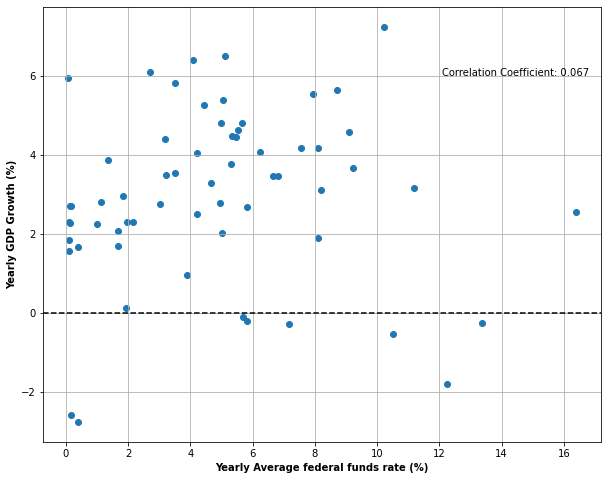

In [6]:
plt.figure(figsize=(10,8))

r = round(pearsonr(df.ffr, df.gdp_growth)[0], 3)
plt.scatter(df.ffr, df.gdp_growth)
plt.axhline(0, ls='--', color='black')
plt.ylabel('Yearly GDP Growth (%)', fontweight='bold')
plt.xlabel('Yearly Average federal funds rate (%)', fontweight='bold')
plt.text(12.1, 6, f'Correlation Coefficient: {r}')
plt.grid()
plt.show()

Looking here, we can see that there is no real correlation between the two. On the surface it seems like lowering the interest rates should lead to higher GDP growth, as it enables banking institutions to more freely lend money to one another and stimulates economic growth. On the contrary, raising interest rates would have the effect of contracting the economy, as banks and by effect individuals are less likely/able to take out loans. However, that is not the picture that is seen here. However, if we look at how the two compare over time, we are able to see that peaks in the FFR (usually enacted to help slow inflation) are usually followed by peaks in the GDP (but a couple years later). 

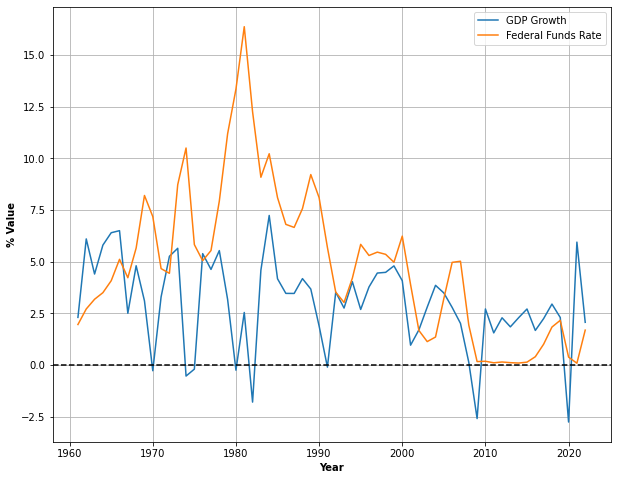

In [7]:
plt.figure(figsize=(10,8))

r = round(pearsonr(df.ffr, df.gdp_growth)[0], 3)
plt.plot(df.year, df.gdp_growth, label='GDP Growth')
plt.plot(df.year, df.ffr, label='Federal Funds Rate')
plt.axhline(0, ls='--', color='black')
plt.ylabel('% Value', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
# plt.text(12.1, 6, f'Correlation Coefficient: {r}')
plt.legend()
plt.grid()
plt.show()

As such, we can instead plot the FFR against what the GDP growth is four years after it was enacted:

In [8]:
gdp_offset = df[['year', 'gdp_growth']]
gdp_offset.columns = ['year', 'gdp_growth_4yr_offset']
gdp_offset['year'] = gdp_df.loc[:, 'year'] - 4
df = df.merge(gdp_offset, how='left', on='year')
df.head()

,year,gdp_growth,gdp_change,ffr,cpi,cpi_change_dec_dec,cpi_change_avg_avg,gdp_growth_4yr_offset
0,1961,2.3,3.8,1.955000,29.9,0.7,1.0,6.4
1,1962,6.1,3.8,2.708333,30.2,1.3,1.0,6.5
2,1963,4.4,-1.7,3.178333,30.6,1.6,1.3,2.5
3,1964,5.8,1.4,3.496667,31.0,1.0,1.3,4.8
4,1965,6.4,0.6,4.075000,31.5,1.9,1.6,3.1


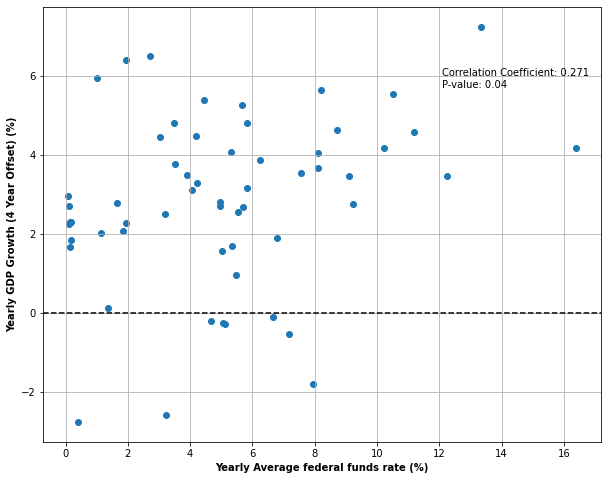

In [9]:
plt.figure(figsize=(10,8))

plt_df = df.dropna()

r = pearsonr(plt_df.ffr, plt_df.gdp_growth_4yr_offset)
plt.scatter(plt_df.ffr, plt_df.gdp_growth_4yr_offset)
plt.axhline(0, ls='--', color='black')
plt.ylabel('Yearly GDP Growth (4 Year Offset) (%)', fontweight='bold')
plt.xlabel('Yearly Average federal funds rate (%)', fontweight='bold')
plt.text(12.1, 6, f'Correlation Coefficient: {round(r[0], 3)}')
plt.text(12.1, 5.70, f'P-value: {round(r[1], 3)}')

plt.grid()
plt.show()

The graph above confirms that strangely enough, the higher FFR has a positive, statistically significant correlation with the GDP growth seen three years after. It's possible that this is due in part to the fact that the FFR usually increases during high periods of inflation in an effort to put on a hold on the economy so that normal conditions economic conditions can again take hold. Its possible that after this 3-year gap, the economy recovers from the effect of the higher interest's rates short-term constriction, and normal GDP growth is again possible. 

## 2.2. Annual GDP Growth Change as a Function of FFR

A similar story can be told when comparing the percent change in annual GDP growth as a function of the annual average FFR. Plotted using the same year, not a clear correlation can be seen: 

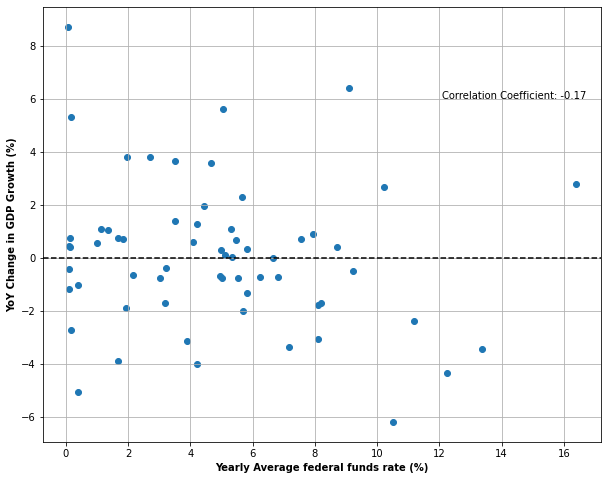

In [10]:
plt.figure(figsize=(10,8))

r = round(pearsonr(df.ffr, df.gdp_change)[0], 3)
plt.scatter(df.ffr, df.gdp_change)
plt.ylabel('YoY Change in GDP Growth (%)', fontweight='bold')
plt.axhline(0, color='black', ls='--')
plt.xlabel('Yearly Average federal funds rate (%)', fontweight='bold')
plt.text(12.1, 6, f'Correlation Coefficient: {r}')
plt.grid()
plt.show()

Looking at the two over time with one another, we can see that the shifting federal funds rate does seem to have a predictable impact on the percent GDP change. Namely, bumps in the FFR seem to eventually result in rises in the GDP change. 

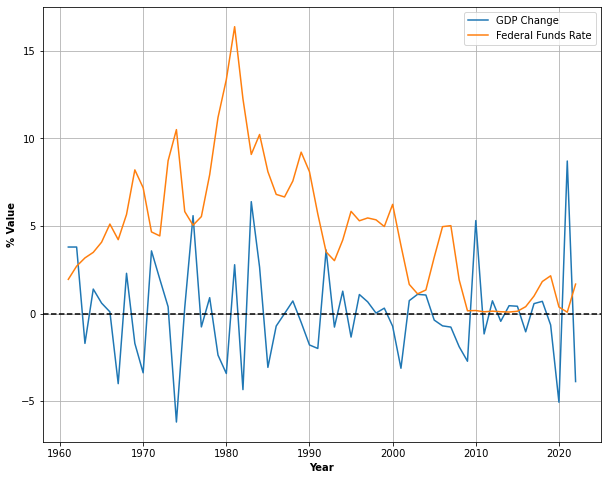

In [11]:
plt.figure(figsize=(10,8))

r = round(pearsonr(df.ffr, df.gdp_growth)[0], 3)
plt.plot(df.year, df.gdp_change, label='GDP Change')
plt.plot(df.year, df.ffr, label='Federal Funds Rate')
plt.axhline(0, ls='--', color='black')
plt.ylabel('% Value', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
# plt.text(12.1, 6, f'Correlation Coefficient: {r}')
plt.legend()
plt.grid()
plt.show()

We can test this again by looking at the impact of the FFR on the GDP change 2 years after they were implemented: 

In [12]:
gdp_offset = df[['year', 'gdp_change']]
gdp_offset.columns = ['year', 'gdp_change_2yr_offset']
gdp_offset['year'] = gdp_df.loc[:, 'year'] - 2
df = df.merge(gdp_offset, how='left', on='year')
df.head()

,year,gdp_growth,gdp_change,ffr,cpi,cpi_change_dec_dec,cpi_change_avg_avg,gdp_growth_4yr_offset,gdp_change_2yr_offset
0,1961,2.3,3.8,1.955000,29.9,0.7,1.0,6.4,-1.7
1,1962,6.1,3.8,2.708333,30.2,1.3,1.0,6.5,1.4
2,1963,4.4,-1.7,3.178333,30.6,1.6,1.3,2.5,0.6
3,1964,5.8,1.4,3.496667,31.0,1.0,1.3,4.8,0.1
4,1965,6.4,0.6,4.075000,31.5,1.9,1.6,3.1,-4.0


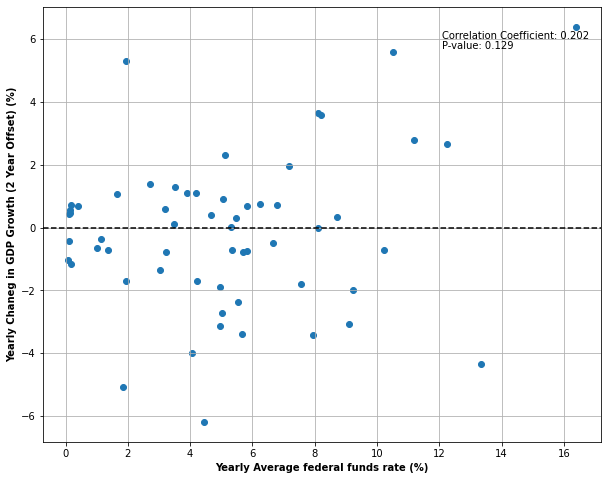

In [13]:
plt.figure(figsize=(10,8))

plt_df = df.dropna()

r = pearsonr(plt_df.ffr, plt_df.gdp_change_2yr_offset)
plt.scatter(plt_df.ffr, plt_df.gdp_change_2yr_offset)
plt.axhline(0, ls='--', color='black')
plt.ylabel('Yearly Chaneg in GDP Growth (2 Year Offset) (%)', fontweight='bold')
plt.xlabel('Yearly Average federal funds rate (%)', fontweight='bold')
plt.text(12.1, 6, f'Correlation Coefficient: {round(r[0], 3)}')
plt.text(12.1, 5.70, f'P-value: {round(r[1], 3)}')

plt.grid()
plt.show()

While the correlation did improve (and become positive, as predicted), it less correlated to the actual GDP growth value. 

## 2.3. Yearly Avg Change In CPI as a Function of FFR

The FFR is most well known as a means to halt inflation and, given 2023 saw some of the highest inflation rates for years, the FED's has recently been in the spotlight for quite some time, raising interest rates as high as 5.5% as of this writing. Raising the FFR helps to lower inflation by reducing activity in the economy, and shrinking demand. Higher interest rates means that less people buy homes, cars, and lend money less in general, meaning they have less to spend. As a result of this shrinking demand, supply has a chance to catch up, eventually lowering the rate at which prices increase. 

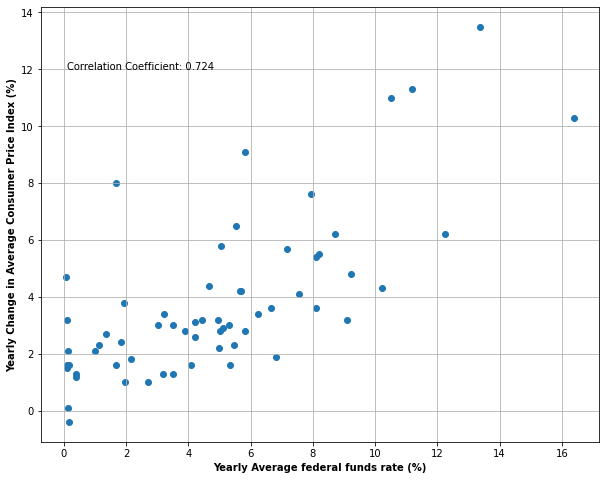

In [14]:
plt.figure(figsize=(10,8))

r = round(pearsonr(df.ffr, df.cpi_change_avg_avg, )[0], 3)
plt.scatter(df.ffr, df.cpi_change_avg_avg)
plt.ylabel('Yearly Change in Average Consumer Price Index (%)', fontweight='bold')
plt.xlabel('Yearly Average federal funds rate (%)', fontweight='bold')
plt.text(0.1, 12, f'Correlation Coefficient: {r}')
plt.grid()
plt.show()

We see in the above graph, given the high correlation between the FFR and change in CPI (a metric for measuring inflation), that high interest rates are typically enacted during times in which the CPI is rising. 